# Notebook structure:
* Categories distribution
* CountVectorizer + LogReg + TfidfVectorizer training with unbalanced dataset
* Balancing dataset
* Training LogReg & GB with Tfidf & CountVectorizer on balanced dataset
* Feature importances + greater&smaller weights
* Trying word2vec + training models

**Dataset:** Top 100 films + low-rating films

**Dataset shape:** 60058∗2

Reviews: reviews without nltk.stopwords, without tags, with lemmatization

In [1]:
%cd ../..

from datasets.getters import  load_reviews_Review_Label_clean

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dill

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.linear_model import LogisticRegression 
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
import nltk
from sklearn.utils import resample
from sklearn.ensemble import GradientBoostingClassifier
import catboost as cb
from gensim.models import Word2Vec

from pprint import pprint

from pymystem3 import Mystem

np.set_printoptions(threshold=np.inf)

In [2]:
reviews = load_reviews_Review_Label_clean()
reviews

review     label
0      «зелёный милю» смотреть раз : 10 год назад сей...   NEUTRAL
1      период конец девяностый годов-начало двухтысяч...  POSITIVE
2      очень сложно писать рецензия фильм , это прост...  POSITIVE
3      любимый многий миллион ценитель киноискусство ...  POSITIVE
4      наш мир существовать разный фильмов. один цепл...  POSITIVE
...                                                  ...       ...
60053  исключение легендарный 'челюсть ' , качественн...   NEUTRAL
60054  действие фильм происходить космический корабле...  NEGATIVE
60055  стоить поверить низкий оценка смотреть фильм ,...  NEGATIVE
60056  повестись , каждый фильм жанр фантастика , кот...  NEGATIVE
60057  последний десятилетие , фон засилье фэнтэзь , ...   NEUTRAL

[60058 rows x 2 columns]

In [3]:
reviews.label.value_counts()

POSITIVE    47847
NEUTRAL      6744
NEGATIVE     5467
Name: label, dtype: int64

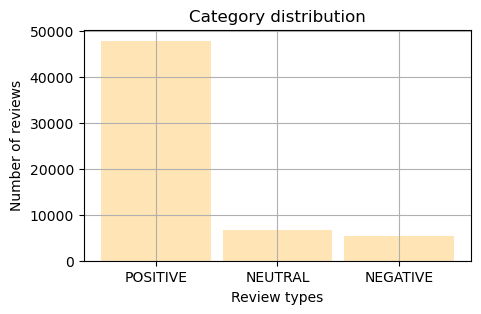

In [4]:
fig, ax = plt.subplots(figsize=(5, 3))

ax.bar(reviews.label.value_counts().index, 
       reviews.label.value_counts().values, 
       color = 'moccasin', width = 0.9)
plt.title("Category distribution")
plt.xlabel("Review types")
plt.ylabel("Number of reviews")
plt.grid(True)

In [5]:
label_encoding = {
    'POSITIVE': 2,
    'NEUTRAL': 1,
    'NEGATIVE': 0
}

In [6]:
reviews.label = reviews.label.apply(lambda label: label_encoding[label])
reviews

review  label
0      «зелёный милю» смотреть раз : 10 год назад сей...      1
1      период конец девяностый годов-начало двухтысяч...      2
2      очень сложно писать рецензия фильм , это прост...      2
3      любимый многий миллион ценитель киноискусство ...      2
4      наш мир существовать разный фильмов. один цепл...      2
...                                                  ...    ...
60053  исключение легендарный 'челюсть ' , качественн...      1
60054  действие фильм происходить космический корабле...      0
60055  стоить поверить низкий оценка смотреть фильм ,...      0
60056  повестись , каждый фильм жанр фантастика , кот...      0
60057  последний десятилетие , фон засилье фэнтэзь , ...      1

[60058 rows x 2 columns]

In [7]:
reviews = reviews[reviews.label != 1].reset_index().drop(columns=['index'])
reviews

review  label
0      период конец девяностый годов-начало двухтысяч...      2
1      очень сложно писать рецензия фильм , это прост...      2
2      любимый многий миллион ценитель киноискусство ...      2
3      наш мир существовать разный фильмов. один цепл...      2
4      1999 год фильм увидел. показывать местный тв. ...      2
...                                                  ...    ...
53309  хотеть знать , 'осторожно ! ребёнок играть ' о...      0
53310  непотопляемый ( право славиться свой долгожите...      2
53311  действие фильм происходить космический корабле...      0
53312  стоить поверить низкий оценка смотреть фильм ,...      0
53313  повестись , каждый фильм жанр фантастика , кот...      0

[53314 rows x 2 columns]

In [8]:
train, test = train_test_split(reviews, test_size=0.3, random_state=42)
print(train.shape, test.shape)
train

(37319, 2) (15995, 2)


review  label
43974  всё-таки продюсерский жадность - дело удивител...      2
20438  самый зрелищный фильм 2007 год — «пират карибс...      2
5134   второй фильм заметно первого. «два крепости» с...      2
6870   микки маус научиться летать , обязательно спас...      2
33304  парить воздух гора , птица удивительный расцве...      2
...                                                  ...    ...
11284  ... ввернуть идея подсознание человек сон ... ...      2
44732  фильм потрясающий. мало , необычен. необычный ...      2
38158  кто-то заметить : человек жаждать сэкономить н...      2
860    фильм , который неизменно занимать первый мест...      2
15795  фильм ждать весь сердце , истинный ценитель тв...      2

[37319 rows x 2 columns]

In [9]:
# cnt_vec_text = CountVectorizer()
# train_vectorized = cnt_vec_text.fit_transform(train.review)
# train_vectorized

In [10]:
# cnt_vec_text.vocabulary_

---

In [11]:
cnt_vec = CountVectorizer(tokenizer=TreebankWordTokenizer().tokenize)
X_train = cnt_vec.fit_transform(train.review)
X_test  = cnt_vec.transform(test.review)

print('CountVectorizing finished.')

clf = LogisticRegression(max_iter=200, n_jobs=-1)
clf.fit(X_train, train.label)
pred = clf.predict(X_test)

print(f1_score(test.label, pred, pos_label=2))
print(f1_score(test.label, pred, pos_label=0))
print(classification_report(test.label, pred))

CountVectorizing finished.
0.9714029459450135
0.7237587470843053
              precision    recall  f1-score   support

           0       0.78      0.68      0.72      1608
           2       0.96      0.98      0.97     14387

    accuracy                           0.95     15995
   macro avg       0.87      0.83      0.85     15995
weighted avg       0.95      0.95      0.95     15995



In [12]:
cnt_vec = TfidfVectorizer(tokenizer=TreebankWordTokenizer().tokenize)
X_train = cnt_vec.fit_transform(train.review)
X_test  = cnt_vec.transform(test.review)

print('TfidfVectorizing finished.')

clf = LogisticRegression(max_iter=200, n_jobs=-1)
clf.fit(X_train, train.label)
pred = clf.predict(X_test)

print(f1_score(test.label, pred, pos_label=2))
print(f1_score(test.label, pred, pos_label=0))
print(classification_report(test.label, pred))

TfidfVectorizing finished.
0.9648058252427185
0.5511607910576096
              precision    recall  f1-score   support

           0       0.89      0.40      0.55      1608
           2       0.94      0.99      0.96     14387

    accuracy                           0.93     15995
   macro avg       0.91      0.70      0.76     15995
weighted avg       0.93      0.93      0.92     15995



In [12]:
cnt_vec = TfidfVectorizer(tokenizer=TreebankWordTokenizer().tokenize)
X_train = cnt_vec.fit_transform(train.review)
X_test  = cnt_vec.transform(test.review)

print('TfidfVectorizing finished.')

clf = LogisticRegression(max_iter=200, n_jobs=-1, class_weight='balanced')
clf.fit(X_train, train.label)
pred = clf.predict(X_train)

print(f1_score(train.label, pred, pos_label=2))
print(f1_score(train.label, pred, pos_label=0))
print(classification_report(train.label, pred))

TfidfVectorizing finished.
0.9723006134969324
0.8086458995549904
              precision    recall  f1-score   support

           0       0.68      0.99      0.81      3859
           2       1.00      0.95      0.97     33460

    accuracy                           0.95     37319
   macro avg       0.84      0.97      0.89     37319
weighted avg       0.97      0.95      0.96     37319



In [14]:
cnt_vec = CountVectorizer(tokenizer=TreebankWordTokenizer().tokenize)
X_train = cnt_vec.fit_transform(train.review)
X_test  = cnt_vec.transform(test.review)

print('CountVectorizing finished.')

clf = LogisticRegression(max_iter=200, n_jobs=-1, class_weight='balanced')
clf.fit(X_train, train.label)
pred = clf.predict(X_test)

print(f1_score(test.label, pred, pos_label=2))
print(f1_score(test.label, pred, pos_label=0))
print(classification_report(test.label, pred))

CountVectorizing finished.
0.9697075208913649
0.7339449541284405
              precision    recall  f1-score   support

           0       0.72      0.75      0.73      1608
           2       0.97      0.97      0.97     14387

    accuracy                           0.95     15995
   macro avg       0.85      0.86      0.85     15995
weighted avg       0.95      0.95      0.95     15995



In [15]:
pred = clf.predict(X_test)

print(f1_score(test.label, pred, pos_label=2))
print(f1_score(test.label, pred, pos_label=0))
print(classification_report(test.label, pred))

0.9697075208913649
0.7339449541284405
              precision    recall  f1-score   support

           0       0.72      0.75      0.73      1608
           2       0.97      0.97      0.97     14387

    accuracy                           0.95     15995
   macro avg       0.85      0.86      0.85     15995
weighted avg       0.95      0.95      0.95     15995



**Почему такая разница в метриках между `CountVectorizer` и `TfidfVectorizer`?**

#### Balancing dataset

[SMOTE: метод увеличения числа примеров миноритарного класса](https://medium.com/nuances-of-programming/smote-%D0%BC%D0%B5%D1%82%D0%BE%D0%B4-%D1%83%D0%B2%D0%B5%D0%BB%D0%B8%D1%87%D0%B5%D0%BD%D0%B8%D1%8F-%D1%87%D0%B8%D1%81%D0%BB%D0%B0-%D0%BF%D1%80%D0%B8%D0%BC%D0%B5%D1%80%D0%BE%D0%B2-%D0%BC%D0%B8%D0%BD%D0%BE%D1%80%D0%B8%D1%82%D0%B0%D1%80%D0%BD%D0%BE%D0%B3%D0%BE-%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B0-da91a62f9914)
> Другим вариантом является увеличение примеров миноритарного класса. Иными словами, случайным образом дублируются образцы миноритарного класса. Проблема этого подхода заключается в том, что он приводит к чрезмерному обучению, поскольку модель обучается на одних и тех же примерах.

In [13]:
train.label.value_counts()

2    33460
0     3859
Name: label, dtype: int64

In [14]:
train

review  label
43974  всё-таки продюсерский жадность - дело удивител...      2
20438  самый зрелищный фильм 2007 год — «пират карибс...      2
5134   второй фильм заметно первого. «два крепости» с...      2
6870   микки маус научиться летать , обязательно спас...      2
33304  парить воздух гора , птица удивительный расцве...      2
...                                                  ...    ...
11284  ... ввернуть идея подсознание человек сон ... ...      2
44732  фильм потрясающий. мало , необычен. необычный ...      2
38158  кто-то заметить : человек жаждать сэкономить н...      2
860    фильм , который неизменно занимать первый мест...      2
15795  фильм ждать весь сердце , истинный ценитель тв...      2

[37319 rows x 2 columns]

In [15]:
train[train.label == 0]

review  label
3007   выйти очередной фильм кристофер нолан , событи...      0
23467  такой предположение , актёр играть ... вообще ...      0
42716  пятнадцать год , первый прочтение книга кизя ,...      0
6700   наделать шум прошлый 2008 год очередной киноко...      0
51369  полнота картина хватать балалайка медведь улиц...      0
...                                                  ...    ...
43021  время просмотр фильм показаться сильный , отме...      0
43323  фильм слышать друг , знакомый вообще мужиков. ...      0
189    слышать фильм заглянуть топ 250 кинопоиска. по...      0
25658  наверно сказать я страшно непопулярный , всё-т...      0
6265   весь мы равный мера свойственно злорадствовать...      0

[3859 rows x 2 columns]

In [16]:
train = pd.concat([train, resample(train[train.label == 0], n_samples=29500, random_state=42)])
train

review  label
43974  всё-таки продюсерский жадность - дело удивител...      2
20438  самый зрелищный фильм 2007 год — «пират карибс...      2
5134   второй фильм заметно первого. «два крепости» с...      2
6870   микки маус научиться летать , обязательно спас...      2
33304  парить воздух гора , птица удивительный расцве...      2
...                                                  ...    ...
25997  представлять свой объективный мнение , ибо кни...      0
52959  понимать , компьютер попасть фильм. серьезно. ...      0
24897  дама господин , фильм настолько разочаровать ,...      0
27699  властелин кольцо безусловно хороший кинотрилог...      0
25658  наверно сказать я страшно непопулярный , всё-т...      0

[66819 rows x 2 columns]

In [17]:
train.label.value_counts()

2    33460
0    33359
Name: label, dtype: int64

#### Training & Exploring `CountVectorizer`

In [11]:
%%time

cnt_vec = CountVectorizer(tokenizer=TreebankWordTokenizer().tokenize, max_df=0.6, max_features=1000)
X_train = cnt_vec.fit_transform(train.review)
print(f'{X_train.shape=}')
X_test  = cnt_vec.transform(test.review)

print('CountVectorizing finished.')

clf = LogisticRegression(max_iter=200, n_jobs=-1)
clf.fit(X_train, train.label)
pred = clf.predict(X_test)

print(f1_score(test.label, pred, pos_label=2))
print(f1_score(test.label, pred, pos_label=0))
print(classification_report(test.label, pred))

X_train.shape=(37319, 1000)
CountVectorizing finished.
0.9626786387470442
0.6125933831376735
              precision    recall  f1-score   support

           0       0.72      0.54      0.61      1608
           2       0.95      0.98      0.96     14387

    accuracy                           0.93     15995
   macro avg       0.83      0.76      0.79     15995
weighted avg       0.93      0.93      0.93     15995

Wall time: 50.7 s


In [19]:
print(len(cnt_vec.get_feature_names_out()))
cnt_vec.get_feature_names_out()[:30]

1000


array(['!', '%', "'", '(', ')', '-', '.', '...', '1', '2', '3', '3d', '4',
       '5', '8', '9', ':', ';', '?', '»', 'абсолютно', 'автор', 'актриса',
       'актёр', 'актёрский', 'алиса', 'америка', 'американец',
       'американский', 'армия'], dtype=object)

In [20]:
# Just watching...
clf.decision_function(X_train[:10])  # Confidence scores for each sample

array([ 2.98113515e+00,  3.78216115e+00, -3.18933806e-01, -3.30459246e+00,
       -1.18534020e-02, -3.86244787e+00,  2.06051868e+00,  1.45943519e-01,
        1.14235978e+00,  1.46798393e+01])

In [21]:
cnt_vec.get_feature_names_out()[np.argpartition(clf.coef_[0], -30)[-30:]]

array(['отдельный', 'замечательный', 'спасибо', 'продолжение', 'обладать',
       'шикарный', 'пересматривать', 'невозможно', 'советовать',
       'приятный', 'отличный', 'вера', 'подобрать', 'приятно', 'элемент',
       'триллер', 'порой', 'одновременно', 'роберт', 'отлично', 'рон',
       'потрясать', '9', 'идеальный', '8', 'идеально', 'суметь',
       'удивительный', 'впервые', 'звучать'], dtype=object)

In [22]:
cnt_vec.get_feature_names_out()[np.argpartition(clf.coef_[0], 30)[:30]]

array(['разочарование', 'пустой', 'откровенно', 'поведение', 'неужели',
       'бред', 'непонятно', 'вместо', 'попытка', 'потратить', 'похоже',
       'увы', '4', '5', 'джейн', 'скучный', 'бедный', 'неплохой',
       'логика', 'середина', 'оценка', 'слабый', 'сожаление', 'рейтинг',
       'голливуд', 'нести', 'видимо', 'банальный', 'глупый', 'надеяться'],
      dtype=object)

In [82]:
np.argpartition(np.abs(clf.coef_[0]), -10)[-10:]

array([519,  20, 583, 205,  35,  21, 408,  18,  17,  16], dtype=int64)

In [19]:
# _X_train = X_train.toarray()
# _X_train.shape

(18569, 1000)

In [37]:
s = np.array(np.sum(X_train, axis=0))[0]
s.shape

(1000,)

In [39]:
np.sort(s)[::-1][:5000]

array([138146, 130778, 116080, 112399, 104244,  98762,  92826,  84273,
        79316,  76593,  75977,  67780,  64852,  58501,  57771,  52409,
        49618,  49334,  48890,  48092,  47169,  46114,  46072,  43608,
        42029,  41457,  41266,  41240,  41100,  40195,  39197,  39095,
        38709,  38365,  37208,  36591,  36559,  36461,  34091,  33717,
        33623,  33306,  33047,  31084,  30643,  29678,  29449,  29198,
        28929,  28716,  28694,  27906,  27858,  27408,  27317,  26830,
        26814,  26491,  26127,  26011,  25932,  25866,  24829,  24784,
        24646,  24564,  24436,  23601,  23543,  23498,  22844,  22534,
        21875,  21371,  21278,  20294,  20284,  19992,  19941,  19896,
        19644,  19588,  19441,  19394,  19003,  18966,  18819,  18468,
        18307,  18271,  18260,  18127,  18081,  17721,  17446,  17218,
        17044,  17016,  16839,  16727,  16707,  16542,  16499,  16337,
        16105,  16023,  15907,  15514,  15436,  15430,  15278,  15265,
      

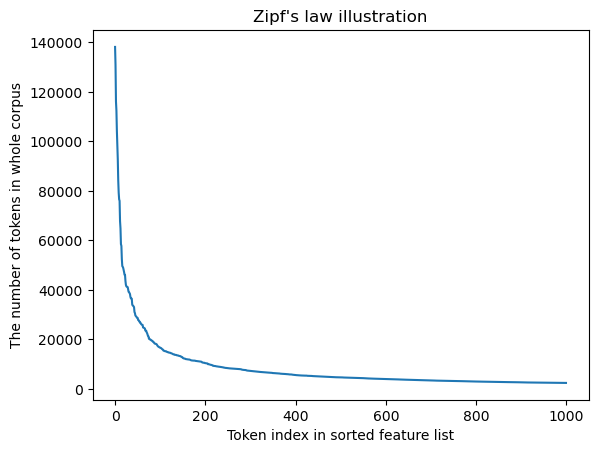

In [40]:
plt.plot(np.sort(s)[::-1])
plt.xlabel('Token index in sorted feature list')
plt.ylabel('The number of tokens in whole corpus')
plt.title("Zipf's law illustration")
plt.show()

#### What if binary coding chosen?

In [41]:
cnt_vec = CountVectorizer(tokenizer=TreebankWordTokenizer().tokenize, max_df=0.6, max_features=1000, binary=True)
X_train = cnt_vec.fit_transform(train.review)
print(f'{X_train.shape=}')
X_test  = cnt_vec.transform(test.review)

print('CountVectorizing finished.')

clf = LogisticRegression(max_iter=200, n_jobs=-1)
clf.fit(X_train, train.label)
pred = clf.predict(X_test)

print(f1_score(test.label, pred, pos_label=2))
print(f1_score(test.label, pred, pos_label=0))
print(classification_report(test.label, pred))

X_train.shape=(66819, 1000)
CountVectorizing finished.
0.9280538681109566
0.5784734133790738
              precision    recall  f1-score   support

           0       0.44      0.84      0.58      1608
           2       0.98      0.88      0.93     14387

    accuracy                           0.88     15995
   macro avg       0.71      0.86      0.75     15995
weighted avg       0.93      0.88      0.89     15995



*Nothing positive happened.*

#### GB Classifier testing

In [42]:
cnt_vec = CountVectorizer(tokenizer=TreebankWordTokenizer().tokenize, max_df=0.6, max_features=1000)
X_train = cnt_vec.fit_transform(train.review)
print(f'{X_train.shape=}')
X_test  = cnt_vec.transform(test.review)

print('CountVectorizing finished.')

clf = GradientBoostingClassifier()
clf.fit(X_train, train.label)
pred = clf.predict(X_test)

print(f1_score(test.label, pred, pos_label=2))
print(f1_score(test.label, pred, pos_label=0))
print(classification_report(test.label, pred))

X_train.shape=(66819, 1000)
CountVectorizing finished.
0.901611218857228
0.4905368868288914
              precision    recall  f1-score   support

           0       0.36      0.79      0.49      1608
           2       0.97      0.84      0.90     14387

    accuracy                           0.84     15995
   macro avg       0.66      0.81      0.70     15995
weighted avg       0.91      0.84      0.86     15995



In [43]:
len(clf.feature_importances_)

1000

In [44]:
cnt_vec.get_feature_names_out()[np.argpartition(clf.feature_importances_, -30)[-30:]]

array(['.', 'увы', 'пустой', 'отлично', 'откровенно', 'непонятно',
       'замечательный', 'скучный', 'великолепный', 'слишком', '?',
       'вообще', 'роль', '9', 'очень', '5', '4', 'настоящий', '3',
       'вместо', 'прекрасный', 'видимо', 'заставлять', 'какой-то',
       'жизнь', 'потрясать', 'никакой', 'каждый', 'разочарование',
       'плохой'], dtype=object)

In [45]:
# Все фичи на букву П!!!

cnt_vec.get_feature_names_out()[np.argpartition(clf.feature_importances_, 30)[:30]]

array(['потерять', 'постоянно', 'природа', 'принять', 'принцип', 'пример',
       'прийтись', 'прийти', 'признаться', 'придумать', 'прежде',
       'предыдущий', 'представлять', 'представить', 'превратиться',
       'практически', 'право', 'правильный', 'правило', 'правда',
       'появляться', 'появление', 'появиться', 'поэтому', 'почему-то',
       'похожий', 'приходить', 'поступок', 'помочь', 'помощь'],
      dtype=object)

#### Training & Exploring `TfidfVectorizer`

In [16]:
tfidf_vec = TfidfVectorizer(tokenizer=TreebankWordTokenizer().tokenize)
X_train = tfidf_vec.fit_transform(train.review)
print(f'{X_train.shape=}')
X_test  = tfidf_vec.transform(test.review)

print('TfidfVectorizing finished.')

clf = LogisticRegression(max_iter=200, n_jobs=-1)
clf.fit(X_train, train.label)
pred = clf.predict(X_test)

print(f1_score(test.label, pred, pos_label=2))
print(f1_score(test.label, pred, pos_label=0))
print(classification_report(test.label, pred))

X_train.shape=(18569, 215812)
TfidfVectorizing finished.
0.9650866462793068
0.6505102040816327
              precision    recall  f1-score   support

           0       0.58      0.75      0.65       341
           2       0.98      0.95      0.97      3975

    accuracy                           0.94      4316
   macro avg       0.78      0.85      0.81      4316
weighted avg       0.95      0.94      0.94      4316



In [17]:
X_train

<18569x215812 sparse matrix of type '<class 'numpy.float64'>'
	with 5013759 stored elements in Compressed Sparse Row format>

In [18]:
_X_train = X_train.toarray()
_X_train.shape

(18569, 215812)

---

# Exploring `CatBoost`

In [51]:
cnt_vec = CountVectorizer(tokenizer=TreebankWordTokenizer().tokenize)
X_train = cnt_vec.fit_transform(train.review)
X_test  = cnt_vec.transform(test.review)

print('CountVectorizing finished.')

cc = cb.CatBoostClassifier()
cc.fit(X_train, train.label)
pred = cc.predict(X_test)

print(f1_score(test.label, pred, pos_label=2))
print(f1_score(test.label, pred, pos_label=0))
print(classification_report(test.label, pred))

CountVectorizing finished.
Learning rate set to 0.061968
0:	learn: 0.6758103	total: 1.23s	remaining: 20m 30s
1:	learn: 0.6608563	total: 2.24s	remaining: 18m 36s
2:	learn: 0.6474764	total: 3.24s	remaining: 17m 55s
3:	learn: 0.6358072	total: 4.26s	remaining: 17m 42s
4:	learn: 0.6260340	total: 5.29s	remaining: 17m 33s
5:	learn: 0.6165603	total: 6.29s	remaining: 17m 21s
6:	learn: 0.6086589	total: 7.31s	remaining: 17m 17s
7:	learn: 0.6007407	total: 8.32s	remaining: 17m 12s
8:	learn: 0.5931707	total: 9.33s	remaining: 17m 6s
9:	learn: 0.5866472	total: 10.3s	remaining: 17m 2s
10:	learn: 0.5797209	total: 11.3s	remaining: 16m 59s
11:	learn: 0.5740128	total: 12.3s	remaining: 16m 54s
12:	learn: 0.5686634	total: 13.3s	remaining: 16m 50s
13:	learn: 0.5638941	total: 14.3s	remaining: 16m 47s
14:	learn: 0.5595242	total: 15.3s	remaining: 16m 44s
15:	learn: 0.5551050	total: 16.3s	remaining: 16m 41s
16:	learn: 0.5511503	total: 17.3s	remaining: 16m 37s
17:	learn: 0.5467125	total: 18.2s	remaining: 16m 34s
1

153:	learn: 0.3529053	total: 2m 31s	remaining: 13m 52s
154:	learn: 0.3522469	total: 2m 32s	remaining: 13m 51s
155:	learn: 0.3516488	total: 2m 33s	remaining: 13m 50s
156:	learn: 0.3510420	total: 2m 34s	remaining: 13m 49s
157:	learn: 0.3504296	total: 2m 35s	remaining: 13m 48s
158:	learn: 0.3498334	total: 2m 36s	remaining: 13m 47s
159:	learn: 0.3491974	total: 2m 37s	remaining: 13m 45s
160:	learn: 0.3484410	total: 2m 38s	remaining: 13m 44s
161:	learn: 0.3477573	total: 2m 39s	remaining: 13m 43s
162:	learn: 0.3470130	total: 2m 40s	remaining: 13m 42s
163:	learn: 0.3462429	total: 2m 41s	remaining: 13m 41s
164:	learn: 0.3456471	total: 2m 42s	remaining: 13m 40s
165:	learn: 0.3449147	total: 2m 43s	remaining: 13m 39s
166:	learn: 0.3443046	total: 2m 44s	remaining: 13m 38s
167:	learn: 0.3436613	total: 2m 44s	remaining: 13m 37s
168:	learn: 0.3430553	total: 2m 45s	remaining: 13m 35s
169:	learn: 0.3424013	total: 2m 46s	remaining: 13m 34s
170:	learn: 0.3416823	total: 2m 47s	remaining: 13m 33s
171:	learn

303:	learn: 0.2736567	total: 4m 55s	remaining: 11m 15s
304:	learn: 0.2733222	total: 4m 56s	remaining: 11m 14s
305:	learn: 0.2729801	total: 4m 57s	remaining: 11m 13s
306:	learn: 0.2726163	total: 4m 57s	remaining: 11m 12s
307:	learn: 0.2722364	total: 4m 58s	remaining: 11m 11s
308:	learn: 0.2717325	total: 4m 59s	remaining: 11m 10s
309:	learn: 0.2713802	total: 5m	remaining: 11m 9s
310:	learn: 0.2709823	total: 5m 1s	remaining: 11m 8s
311:	learn: 0.2705710	total: 5m 2s	remaining: 11m 7s
312:	learn: 0.2701562	total: 5m 3s	remaining: 11m 6s
313:	learn: 0.2697875	total: 5m 4s	remaining: 11m 5s
314:	learn: 0.2694287	total: 5m 5s	remaining: 11m 4s
315:	learn: 0.2691391	total: 5m 6s	remaining: 11m 3s
316:	learn: 0.2687603	total: 5m 7s	remaining: 11m 2s
317:	learn: 0.2683452	total: 5m 8s	remaining: 11m 1s
318:	learn: 0.2680008	total: 5m 9s	remaining: 11m
319:	learn: 0.2677118	total: 5m 10s	remaining: 10m 59s
320:	learn: 0.2674035	total: 5m 11s	remaining: 10m 58s
321:	learn: 0.2669759	total: 5m 12s	

455:	learn: 0.2273743	total: 7m 19s	remaining: 8m 44s
456:	learn: 0.2271344	total: 7m 20s	remaining: 8m 43s
457:	learn: 0.2268402	total: 7m 21s	remaining: 8m 42s
458:	learn: 0.2265672	total: 7m 22s	remaining: 8m 41s
459:	learn: 0.2262736	total: 7m 23s	remaining: 8m 40s
460:	learn: 0.2259759	total: 7m 24s	remaining: 8m 39s
461:	learn: 0.2258617	total: 7m 25s	remaining: 8m 38s
462:	learn: 0.2255871	total: 7m 26s	remaining: 8m 37s
463:	learn: 0.2252917	total: 7m 27s	remaining: 8m 36s
464:	learn: 0.2250897	total: 7m 28s	remaining: 8m 35s
465:	learn: 0.2248246	total: 7m 29s	remaining: 8m 34s
466:	learn: 0.2245531	total: 7m 30s	remaining: 8m 33s
467:	learn: 0.2243236	total: 7m 31s	remaining: 8m 32s
468:	learn: 0.2240828	total: 7m 32s	remaining: 8m 31s
469:	learn: 0.2238874	total: 7m 33s	remaining: 8m 30s
470:	learn: 0.2236371	total: 7m 34s	remaining: 8m 29s
471:	learn: 0.2233723	total: 7m 35s	remaining: 8m 28s
472:	learn: 0.2230953	total: 7m 35s	remaining: 8m 28s
473:	learn: 0.2228439	total:

608:	learn: 0.1950601	total: 9m 44s	remaining: 6m 15s
609:	learn: 0.1948272	total: 9m 45s	remaining: 6m 14s
610:	learn: 0.1946318	total: 9m 46s	remaining: 6m 13s
611:	learn: 0.1944797	total: 9m 47s	remaining: 6m 12s
612:	learn: 0.1943933	total: 9m 48s	remaining: 6m 11s
613:	learn: 0.1942013	total: 9m 49s	remaining: 6m 10s
614:	learn: 0.1939955	total: 9m 50s	remaining: 6m 9s
615:	learn: 0.1938179	total: 9m 50s	remaining: 6m 8s
616:	learn: 0.1935737	total: 9m 51s	remaining: 6m 7s
617:	learn: 0.1933685	total: 9m 52s	remaining: 6m 6s
618:	learn: 0.1931710	total: 9m 53s	remaining: 6m 5s
619:	learn: 0.1929833	total: 9m 54s	remaining: 6m 4s
620:	learn: 0.1927307	total: 9m 55s	remaining: 6m 3s
621:	learn: 0.1926690	total: 9m 56s	remaining: 6m 2s
622:	learn: 0.1924810	total: 9m 57s	remaining: 6m 1s
623:	learn: 0.1923314	total: 9m 58s	remaining: 6m
624:	learn: 0.1921626	total: 9m 59s	remaining: 5m 59s
625:	learn: 0.1919132	total: 10m	remaining: 5m 58s
626:	learn: 0.1917071	total: 10m 1s	remainin

759:	learn: 0.1702821	total: 12m 6s	remaining: 3m 49s
760:	learn: 0.1701503	total: 12m 7s	remaining: 3m 48s
761:	learn: 0.1700271	total: 12m 8s	remaining: 3m 47s
762:	learn: 0.1698824	total: 12m 9s	remaining: 3m 46s
763:	learn: 0.1696978	total: 12m 10s	remaining: 3m 45s
764:	learn: 0.1695048	total: 12m 11s	remaining: 3m 44s
765:	learn: 0.1694476	total: 12m 12s	remaining: 3m 43s
766:	learn: 0.1692847	total: 12m 13s	remaining: 3m 42s
767:	learn: 0.1690919	total: 12m 14s	remaining: 3m 41s
768:	learn: 0.1689838	total: 12m 15s	remaining: 3m 40s
769:	learn: 0.1688499	total: 12m 16s	remaining: 3m 39s
770:	learn: 0.1686909	total: 12m 16s	remaining: 3m 38s
771:	learn: 0.1685674	total: 12m 17s	remaining: 3m 37s
772:	learn: 0.1685243	total: 12m 18s	remaining: 3m 36s
773:	learn: 0.1684583	total: 12m 19s	remaining: 3m 36s
774:	learn: 0.1682695	total: 12m 20s	remaining: 3m 35s
775:	learn: 0.1680994	total: 12m 21s	remaining: 3m 34s
776:	learn: 0.1679409	total: 12m 22s	remaining: 3m 33s
777:	learn: 0.

910:	learn: 0.1511931	total: 14m 28s	remaining: 1m 24s
911:	learn: 0.1511385	total: 14m 29s	remaining: 1m 23s
912:	learn: 0.1510063	total: 14m 30s	remaining: 1m 22s
913:	learn: 0.1509808	total: 14m 31s	remaining: 1m 22s
914:	learn: 0.1508704	total: 14m 32s	remaining: 1m 21s
915:	learn: 0.1507366	total: 14m 33s	remaining: 1m 20s
916:	learn: 0.1506116	total: 14m 34s	remaining: 1m 19s
917:	learn: 0.1505662	total: 14m 35s	remaining: 1m 18s
918:	learn: 0.1505291	total: 14m 36s	remaining: 1m 17s
919:	learn: 0.1503917	total: 14m 37s	remaining: 1m 16s
920:	learn: 0.1502862	total: 14m 38s	remaining: 1m 15s
921:	learn: 0.1502302	total: 14m 39s	remaining: 1m 14s
922:	learn: 0.1501221	total: 14m 40s	remaining: 1m 13s
923:	learn: 0.1499784	total: 14m 41s	remaining: 1m 12s
924:	learn: 0.1497998	total: 14m 42s	remaining: 1m 11s
925:	learn: 0.1496558	total: 14m 43s	remaining: 1m 10s
926:	learn: 0.1495304	total: 14m 44s	remaining: 1m 9s
927:	learn: 0.1494571	total: 14m 44s	remaining: 1m 8s
928:	learn: 

ValueError: X has 380090 features, but GradientBoostingClassifier is expecting 1000 features as input.

In [52]:
pred = cc.predict(X_test)

print(f1_score(test.label, pred, pos_label=2))
print(f1_score(test.label, pred, pos_label=0))
print(classification_report(test.label, pred))

0.9570586982752503
0.6825813221406086
              precision    recall  f1-score   support

           0       0.59      0.81      0.68      1608
           2       0.98      0.94      0.96     14387

    accuracy                           0.92     15995
   macro avg       0.78      0.87      0.82     15995
weighted avg       0.94      0.92      0.93     15995



In [56]:
cc.feature_importances_

array([1.02227799e-01, 8.63468502e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.08332622e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [57]:
cc.feature_names_

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138'

*Got baseline for `CatBoost`*

In [55]:
cnt_vec = CountVectorizer(tokenizer=TreebankWordTokenizer().tokenize)
X_train = cnt_vec.fit_transform(train.review)
X_test  = cnt_vec.transform(test.review)

print('CountVectorizing finished.')

cc = cb.CatBoostClassifier(thread_count=12)
cc.fit(X_train, train.label)
pred = cc.predict(X_test)

print(f1_score(test.label, pred, pos_label=2))
print(f1_score(test.label, pred, pos_label=0))
print(classification_report(test.label, pred))

KeyboardInterrupt: 